In [ ]:
import csv
import cv2
import numpy as np

lines =[]

with open('savedata/driving_log.csv') as csvfile:
    reader=csv.reader(csvfile)
    for line in reader:
        lines.append(line)
images=[]
measurements=[]
for line in (lines):
    for i in range(3):
        source_path = line[i]
        file_name = source_path.split('/')[-1]
        current_path ='savedata/IMG/' + file_name
        image = cv2.imread(current_path)
        images.append(image)
    measurementc = float (line[3])
    measurementl = measurementc + 0.15
    measurementr = measurementc - 0.2
    measurements.append(measurementc)
    measurements.append(measurementl)
    measurements.append(measurementr)
    

augmented_images=[]
augmented_measurements = []

for image,measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)


    
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
print(X_train.shape)
print(y_train.shape)

In [ ]:
### Import necessary tool boxes.

import csv
import cv2
import numpy as np
import sklearn
import os

lines =[]
# read the data from CSV file

with open('data1/driving_log.csv') as csvfile:
    reader=csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
## load the data and spilt it into validation and training data.
sampels= lines[1:]  
sklearn.utils.shuffle(sampels)
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(sampels, test_size=0.2)

## generatorr for training and validation of data set.
def generator(sampels, batch_size=128):
    num_samples = len(sampels)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(sampels)
        for offset in range(0, num_samples, batch_size):
            batch_samples = sampels[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = 'data1/IMG/'+batch_sample[0].split('/')[-1]
                image = cv2.imread(name)
                center_image= preprocess_image(generate_shadow(brightness_img(image)))
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                name = 'data1/IMG/'+batch_sample[1].split('/')[-1]
                image2 = cv2.imread(name)
                left_image= preprocess_image(generate_shadow(brightness_img(image2)))
                images.append(left_image)
                left_angle = center_angle  + 0.18
                angles.append(left_angle)
                name = 'data1/IMG/'+batch_sample[2].split('/')[-1]
                image3 = cv2.imread(name)
                right_image= preprocess_image(generate_shadow(brightness_img(image3)))
                images.append(right_image)
                right_angle = center_angle -0.18
                angles.append(right_angle)
                if abs(center_angle) > 0.3 :
                    flip_cimage, flip_cangle = flip_img(center_image, center_angle)
                    images.append(flip_cimage)
                    angles.append(flip_cangle)
                    
                    flip_limage, flip_langle = flip_img(left_image, left_angle)
                    images.append(flip_limage)
                    angles.append(flip_langle)
                        
                    flip_rimage, flip_rangle = flip_img(right_image, right_angle)
                    images.append(flip_rimage)
                    angles.append(flip_rangle)
                    
                    
                

            
            X_train = np.array(images)
            y_train = np.array(angles)
           # print(X_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)


In [2]:
## preprocess the image such as crop, gaussian blur , resize and colorspace change
def preprocess_image(img):
    '''
    Method for preprocessing images: this method is the same used in drive.py, except this version uses
    BGR to YUV and drive.py uses RGB to YUV (due to using cv2 to read the image here, where drive.py images are 
    received in RGB)
    '''

    # crop to 40x320x3
    new_img = img[60:140,:,:]
    # apply subtle blur
    new_img = cv2.GaussianBlur(new_img, (3,3), 0)
    # scale to 66x200x3 
    new_img = cv2.resize(new_img,(200, 66), interpolation = cv2.INTER_AREA)
    # convert to YUV color space (as nVidia paper suggests)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img

In [3]:
### Apply data augmentation techniques such as translate the image, change the bightness of the image
### Apply shadow to image and flip the image.

def shift_img(image, steer):
    """
    randomly shift image horizontally
    add proper steering angle to each image
    """
    max_shift = 55
    max_ang = 0.14  # ang_per_pixel = 0.0025

    rows, cols, _ = image.shape

    random_x = np.random.randint(-max_shift, max_shift + 1)
    dst_steer = steer + (random_x / max_shift) * max_ang
    if abs(dst_steer) > 1:
        dst_steer = -1 if (dst_steer < 0) else 1

    mat = np.float32([[1, 0, random_x], [0, 1, 0]])
    dst_img = cv2.warpAffine(image, mat, (cols, rows))
    return dst_img, dst_steer

def brightness_img(image):
    """
    randomly change brightness by converting Y value
    """
    br_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    coin = np.random.randint(2)
    if coin == 0:
        random_bright = 0.2 + np.random.uniform(0.2, 0.6)
        br_img[:, :, 2] = br_img[:, :, 2] * random_bright
    br_img = cv2.cvtColor(br_img, cv2.COLOR_HSV2BGR)
    return br_img

def generate_shadow(image, min_alpha=0.5, max_alpha = 0.75):
    """generate random shadow in random region"""

    top_x, bottom_x = np.random.randint(0, 64, 2)
    coin = np.random.randint(2)
    rows, cols, _ = image.shape
    shadow_img = image.copy()
    if coin == 0:
        rand = np.random.randint(2)
        vertices = np.array([[(50, 65), (45, 0), (145, 0), (150, 65)]], dtype=np.int32)
        if rand == 0:
            vertices = np.array([[top_x, 0], [0, 0], [0, rows], [bottom_x, rows]], dtype=np.int32)
        elif rand == 1:
            vertices = np.array([[top_x, 0], [cols, 0], [cols, rows], [bottom_x, rows]], dtype=np.int32)
        mask = image.copy()
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (0,) * channel_count
        cv2.fillPoly(mask, [vertices], ignore_mask_color)
        rand_alpha = np.random.uniform(min_alpha, max_alpha)
        cv2.addWeighted(mask, rand_alpha, image, 1 - rand_alpha, 0., shadow_img)

    return shadow_img

def flip_img(image, steering):
    """ randomly flip image to gain right turn data """
    flip_image, flip_steering = cv2.flip(image, 1), -steering
    return flip_image, flip_steering

In [19]:
### Visualization of data augmentation tecniques. 
batch_samples = sampels[300:301]
for batch_sample in batch_samples:
    name = 'data1/IMG/'+batch_sample[0].split('/')[-1]
    image = cv2.imread(name)
    center_steering = float(batch_sample[3])
    center_image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    flip_image, flip_steer = flip_img(center_image, center_steering)
    shift_image, shift_steer = shift_img(center_image, center_steering)
    brightness_image = brightness_img(center_image)
    shadow_image = generate_shadow(center_image)
    

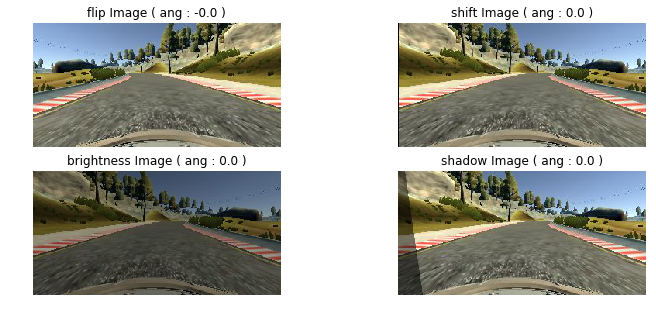

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.imshow(flip_image)
plt.title('flip Image ( ang : ' + str(np.round(flip_steer)) + ' )')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(shift_image)
plt.title('shift Image ( ang : ' + str(np.round(shift_steer)) + ' )')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(brightness_image)
plt.title('brightness Image ( ang : ' + str(np.round(center_steering)) + ' )')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(shadow_image)
plt.title('shadow Image ( ang : ' + str(np.round(center_steering)) + ' )')
plt.axis('off')
plt.show()

In [4]:
## define training generator and validation generator
train_generator = generator(train_samples, batch_size=64)
validation_generator = generator(validation_samples, batch_size=64)

In [5]:
# Define Keras model according to NVidia's model with dropout and lamda layer.

from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(66,200,3)))
#model.add(Cropping2D(cropping=((70,20), (0,0))))
model.add (Convolution2D(24,5,5, subsample= (2,2), activation="elu"))
model.add (Convolution2D(36,5,5, subsample= (2,2), activation="elu"))
model.add (Dropout(0.5))
model.add (Convolution2D(48,5,5, subsample= (2,2), activation="elu"))
model.add (Convolution2D(64,3,3,activation="elu"))
model.add( Dropout(0.5))
model.add (Convolution2D(64,3,3,activation="elu"))
#model.add (MaxPooling2D())
model.add (Flatten())
model.add (Dense(100))
model.add (Dense(50))
model.add (Dense(10))
model.add (Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit_generator(train_generator, samples_per_epoch = 36330, validation_data=validation_generator, nb_val_samples=5400, nb_epoch=3, verbose=1)
model.save ('modeltr1.h5')


Using TensorFlow backend.


Epoch 1/3
36168/36330 [============================>.] - ETA: 1s - loss: 0.0567

/home/shashank/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


36366/36330 [==============================] - 440s - loss: 0.0565 - val_loss: 0.0290
Epoch 2/3
36402/36330 [==============================] - 407s - loss: 0.0285 - val_loss: 0.0276
Epoch 3/3
36417/36330 [==============================] - 442s - loss: 0.0265 - val_loss: 0.0251


dict_keys(['loss', 'val_loss'])


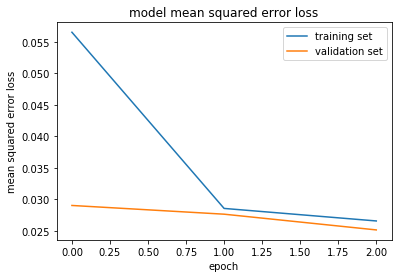

In [6]:
## Visuaization of losses in Model
import matplotlib.pyplot as plt



print(history.history.keys())


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
